In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import cm as CM

import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy import stats
import tensorflow as tf

project_root = '..'
sys.path.append(project_root)

from sleeprnn.nn.spectrum import compute_wavelets, apply_wavelets_rectangular
from sleeprnn.helpers import reader, plotter, printer, misc, performer
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
viz.notebook_full_width()

### General settings

In [2]:
general_lw = 1.0
signal_lw = 0.8
dpi = viz.DPI
general_color = viz.GREY_COLORS[9]
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['blue'] # viz.PALETTE['cyan'] # viz.PALETTE['blue']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']
pred_color = viz.PALETTE['red']

### SS and KC example

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
1044 SS stamps.
409 KC stamps.


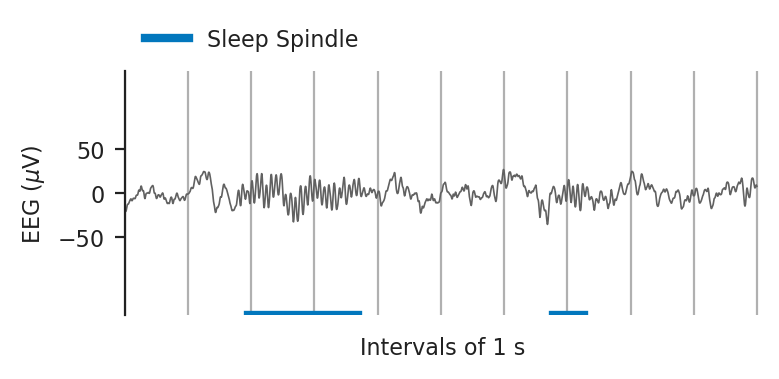

In [3]:
subject_id = 1
which_kc_stamp = 195
left_context = -2#4
right_context = 12#6
y_max = 140
y_min = -140
figsize = (4, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs

fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)

ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min, y_min], label=label, 
        color=ss_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=ss_color, alpha=alpha, label=label)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min, y_min], label=label, 
        color=kc_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=kc_color, alpha=alpha, label=label)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
for lh in lg.legendHandles:
    lh.set_alpha(min(2 * alpha, 1.0))

# Change color of plot
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)
plt.tight_layout()

# plt.savefig("ss_kc_example.eps")

plt.show()

### CWT

In [4]:
subject_id = 1
which_kc_stamp = 195
left_context = -2#4
right_context = 12#6
y_max = 140
y_min = -140
figsize = (4, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1
n_scales = 32

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs

# Build computational for CWT

border_size = int(5 * fs)
segment_signal_cwt = signal[start_sample - border_size:end_sample + border_size]
tf.reset_default_graph()
inputs = tf.placeholder(
    dtype=tf.float32, shape=[None, segment_signal_cwt.size], name="feats_train_ph")
wavelets, frequencies = compute_wavelets(
    fb_list=[0.5],
    fs=fs,
    lower_freq=0.5,
    upper_freq=30,
    n_scales=n_scales,
    size_factor=1.0,
    flattening=False,
    trainable=False,
    name='cmorlet')
outputs = apply_wavelets_rectangular(
    inputs=inputs,
    wavelets=wavelets,
    border_crop=border_size,
    stride=1,
    name='cwt')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
results, kernels = sess.run([outputs, wavelets], feed_dict={inputs: [segment_signal_cwt]})
results_real = results[0, ..., 0]
results_imag = results[0, ..., 1]
kernels_real = np.squeeze(kernels[0][0])
kernels_imag = np.squeeze(kernels[0][1])
cwt_magnitude = np.sqrt(results_real ** 2 + results_imag ** 2).T
print('Done')

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded


W0602 16:33:50.018893 140708362417984 deprecation_wrapper.py:119] From ../sleeprnn/nn/spectrum.py:146: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0602 16:33:50.027160 140708362417984 deprecation_wrapper.py:119] From ../sleeprnn/nn/spectrum.py:155: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.



Global STD: 16.482042
1044 SS stamps.
409 KC stamps.
Done


[30.         26.28824157 23.0357215  20.18562038 17.68814883 15.49967764
 13.58197567 11.90154191 10.4290203   9.13868683  8.00800023  7.01720816
  6.1490021   5.38821509  4.72155666  4.13738074  3.62548215  3.17691835
  2.78385323  2.43942021  2.13760226  1.87312682  1.64137368  1.43829426
  1.2603409   1.10440486  0.96776206  0.84802543  0.74310324  0.65116259
  0.57059731  0.5       ]


<IPython.core.display.Javascript object>


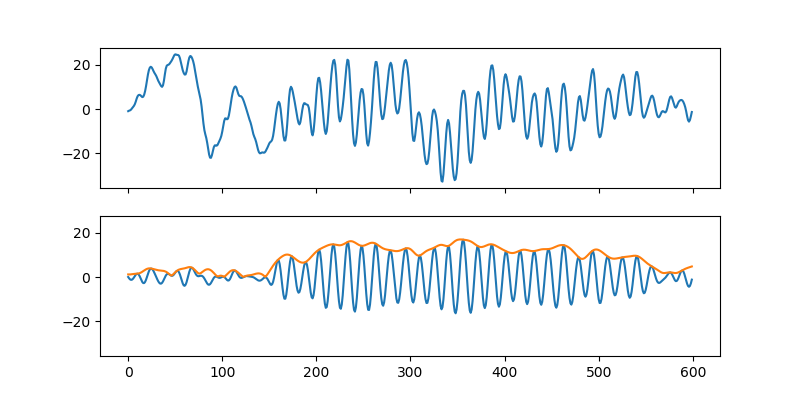

In [19]:
%matplotlib notebook

print(frequencies)
idx_freq = 6
start_sample = 200
end_sample = 800

fig, ax = plt.subplots(2, 1, figsize=(8, 4), dpi=100, sharex=True, sharey=True)
ax[0].plot(segment_signal[start_sample:end_sample])
ax[1].plot(results_real[start_sample:end_sample, idx_freq])
segment_magnitude = np.sqrt(results_real[start_sample:end_sample, idx_freq] ** 2 + results_imag[start_sample:end_sample, idx_freq] ** 2)
ax[1].plot(segment_magnitude)
plt.show()

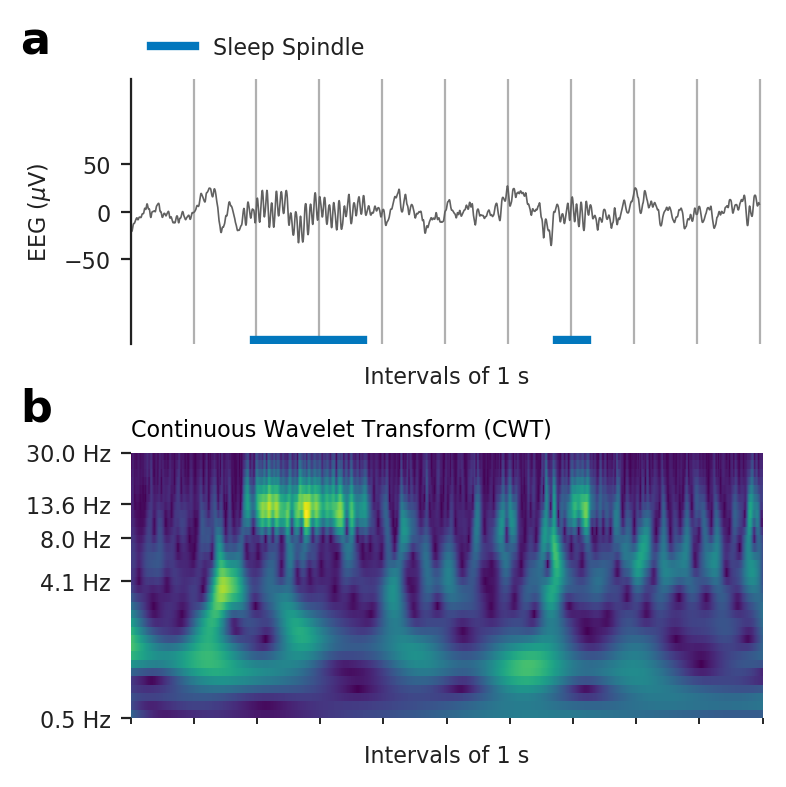

In [6]:
fig, axes = plt.subplots(2, 1, dpi=dpi, figsize=(4, 4))

ax = axes[0]
ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min+5, y_min+5], label=label, 
        color=ss_color, linewidth=linewidth_mark)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min+5, y_min+5], label=label, 
        color=kc_color, linewidth=linewidth_mark)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)

ax = axes[1]
# CWT
ax = axes[1]
ax.set_title('Continuous Wavelet Transform (CWT)', fontsize=viz.FONTSIZE_GENERAL, loc='left')
ax.imshow(
    cwt_magnitude, interpolation='none',
    extent=[time_axis[0], time_axis[-1], 0, 1], aspect='auto')
ax.set_xticks([])
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
freq_pos = np.linspace(0, 1, n_scales)
freq_val = frequencies[::-1]
val_to_show = [0.5, 4, 8, 13, 30]
idx_useful = [misc.closest_index(single_val, freq_val) for single_val in val_to_show]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax = plotter.set_axis_color(ax, general_color)

plt.tight_layout()

plt.text(
    x=0.03, y=0.93, fontsize=16, 
    s=r"$\bf{a}$", 
    ha="left", transform=fig.transFigure)#, color=general_color)
plt.text(
    x=0.03, y=0.47, fontsize=16, 
    s=r"$\bf{b}$", 
    ha="left", transform=fig.transFigure)#, color=general_color)
plt.show()